In [168]:
# word feature vector:
# In natural language processing (NLP), a word embedding is a representation of a word. 
# The embedding is used in text analysis. Typically, the representation is a real-valued 
# vector that encodes the meaning of the word in such a way that words that are closer in 
# the vector space are expected to be similar in meaning. Word embeddings can be obtained 
# using language modeling and feature learning techniques, where words or phrases from the 
# vocabulary are mapped to vectors of real numbers. 
# https://en.wikipedia.org/wiki/Word_embedding
# https://www.youtube.com/watch?v=gQddtTdmG_8
# https://www.baeldung.com/cs/dimensionality-word-embeddings

In [169]:
# at first the words are initialized and spread out randomly
# then, we're gonna tune embeddings of these words using backprop
# by maximizing the log-likelihood

In [170]:
# continuation of mlp_ep2

In [171]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [172]:
# load ~32000 names from a file, one in each line
with open("names.txt", "r") as infile:
    words = infile.read().splitlines() # ignores \n

In [173]:
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [174]:
len(words)

32033

In [175]:
chars = sorted(set("".join(words) + "."))
vocab_size = len(chars)
vocab_size

27

In [176]:
ctoi = {c: i for i, c in enumerate(chars)}

In [177]:
itoc = {i: c for c, i in ctoi.items()}

In [178]:
# building a neural network that takes three (or context_len) characters (a context)
# each character has an embedding in a lookup table
# the nn has 27 outputs corresponding to a letter that we expect to get from a given context
# we will check that using our Y tensor

In [179]:
# building the dataset (with contexts)

# training split -> ~80% -> optimize parameters of the model using gradient descent
# dev/validation split -> ~10% -> hyperparameter tuning
# test split -> ~10% -> evaluate model's final performance

# updated so that we can also create dev/test splits

context_len = 4 # context length - how many chars to take into account to predict the next one?

def build_dataset(words):
    X, Y = [], [] # X - input to the neural net, Y - expected labels for each example inside X
    
    for w in words:
        # print(w)
        context = [0] * context_len # ...
        for c in w + ".":
            idx = ctoi[c]
            X.append(context)
            Y.append(idx)
            # print("".join(itoc[i] for i in context), "--->", itoc[idx])
            context = context[1:] + [idx]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xtest, Ytest = build_dataset(words[n2:])

torch.Size([182625, 4]) torch.Size([182625])
torch.Size([22655, 4]) torch.Size([22655])
torch.Size([22866, 4]) torch.Size([22866])


In [180]:
# TESTS AND EXPERIMENTS IN THE PREVIOUS NOTEBOOK!

In [181]:
# NOW EVERYTHING ORGANIZED:

In [182]:
Xtr.shape, Ytr.shape # the dataset

(torch.Size([182625, 4]), torch.Size([182625]))

In [328]:
-torch.tensor(1/27).log() # that's the initial loss that we're aiming for

tensor(3.2958)

In [395]:
hidden_n = 200
emb_dim = 8

gen = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, emb_dim), generator=gen)
W1 = torch.randn((emb_dim * context_len, hidden_n), generator=gen) * (5/3)/(emb_dim * context_len)**0.5 # Kaiming init, so that the preact values are not too extreme for the tanh (so that it doesn't get too saturated)
# b1 = torch.randn(hidden_n, generator=gen) # not needed when using BatchNorm, bnbias does its job
W2 = torch.randn((hidden_n, vocab_size), generator=gen) * 0.01 # so that the activations take less extreme values and the initial loss is lower
b2 = torch.randn(vocab_size, generator=gen) * 0 # because we don't want any bias at the initialization, we're aiming for values close to 0

# BatchNorm parameters
# bngain and bnbias are needed because we need the activations to be roughly unit Gaussian only at initialization
# later, we would like it to be modifiable by the neural net using backprop. We don't want to force it to be Gaussian
bngain = torch.ones((1, hidden_n)) # trained using backprop
bnbias = torch.zeros((1, hidden_n))
bnmean_running = torch.zeros((1, hidden_n)) # not trained by backprop, calculated in the torch.no_grad() section instead
bnstd_running = torch.ones((1, hidden_n))
eps = 1e-5

parameters = [C, W1, W2, b2, bngain, bnbias]

In [396]:
sum(p.numel() for p in parameters) # numel <=> nelement

12443

In [397]:
for p in parameters:
    p.requires_grad = True

In [398]:
# BatchNorm, other stuff:
# - used to control the statistics of activations in the neural net
# - it also causes to "couple" the randomly chosen examples in a batch together, so that their gradients now depend on each other
# so now the activations of a single example depend on other examples in a batch, because mean and std are different for different examples
# but it actually is not bad, it works as kind of a regularizer, makes it harder to overfit these specific examples

In [399]:
epochs = 200_000
minibatch_size = 64

loss_i = []
step_i = 0

for i in range(epochs):
    # create a minibatch
    idx = torch.randint(0, Xtr.shape[0], (minibatch_size,)) # get minibatch_size random ints between 0 and 228146 (number of contexts), that will be our minibatch
    Xb, Yb = Xtr[idx], Ytr[idx] # batch X and Y
    
    # forward pass
    emb = C[Xb]
    h_preact = emb.view(-1, emb_dim * block_size) @ W1 #+ b1 # bias not needed when using BatchNorm, normalization deletes it anyway (by mean subtraction)
    # BatchNorm
    # we're doing this, because:
    # - we don't want the activations passed to tanh be too small, because tanh is pretty inactive (close to linear function)
    # - but we don't want the values to be too small or too big as well, because then the tanh is too saturated and the gradients get close to 0
        # I understand it as losing information because for extreme values the tanh value is either -1 or 1. No matter if the activation
        # is 10, 50 or 100, the tanh will be more or less 1.
    # it would be the best if the activations were roughly Gaussian, at least in the initialization
    bnmeani = h_preact.mean(0, keepdim=True) # calculate the mean of pre-activation values (mean value over a whole batch (0th dim) -> shape (1, n_hidden)
    bnstdi = h_preact.std(0, keepdim=True) # same as above, but standard deviation. Keepdim so that it's (1, n_hidden) and not (n_hidden)
    # h_preact is shape (minibatch_size, n_hidden)
    h_preact = bngain * ((h_preact - bnmeani) / (bnstdi + eps)) + bnbias # center the batch activations to be unit Gaussian (a normal distribution such that the mean μ = 0 and std σ = 1)
    with torch.no_grad(): # used later, when evaluating loss
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

    # forward pass
    h = torch.tanh(h_preact) # hidden layer, (minibatch_size, hidden_n)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Yb) # more efficient, prevents inf and nan for big positive logits
    loss_i.append(loss.item())
    step_i += 1
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward() # it works -> see computational graph
    
    # update
    lr = 0.1 if i < epochs / 2 else 0.01
    for i, p in enumerate(parameters):
        if p.grad == None:
            print(i)
        p.data += -lr * p.grad

    break

print(loss.item())
# impossible to reach loss 0 because: ... -> e but also ... -> a, etc.

3.312126874923706


torch.Size([64, 200])


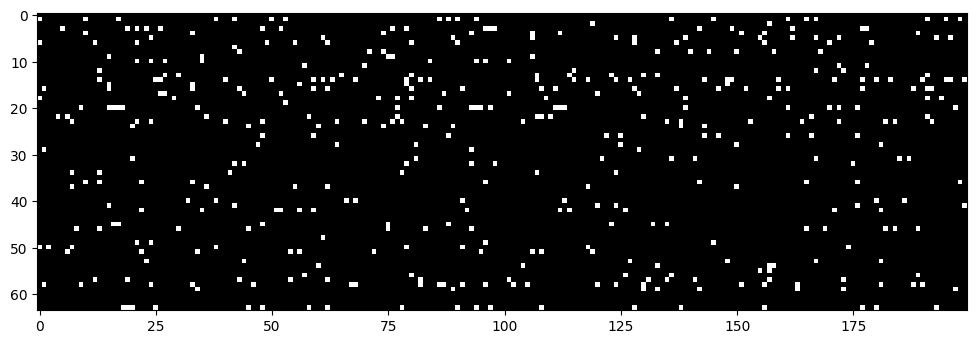

In [400]:
print(h.shape)
plt.figure(figsize=(12, 8))
precision = 0.97
plt.imshow(h.abs() > precision, cmap="gray", interpolation="nearest")
for i in range(h.shape[1]):
    if all(h[:, i].abs() > precision):
        print(f"im dead {i}") # whole column white -> dead neuron

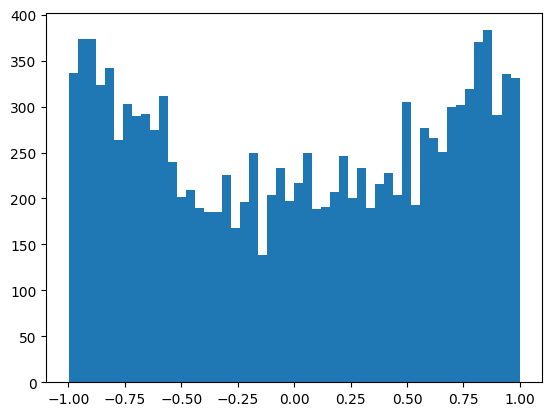

In [401]:
plt.hist(h.view(-1).tolist(), 50); # BatchNorm makes hell of a difference here!!!

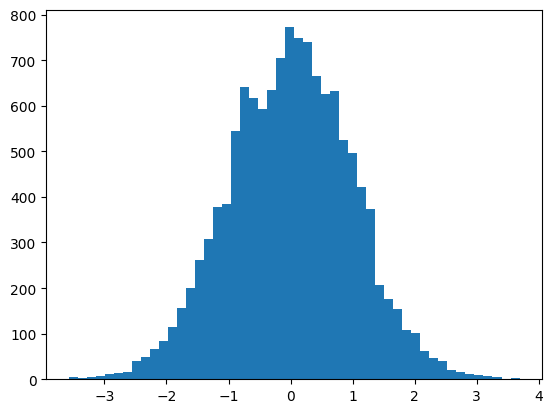

In [402]:
plt.hist(h_preact.view(-1).tolist(), 50); # tanh(2) ~= 0.96

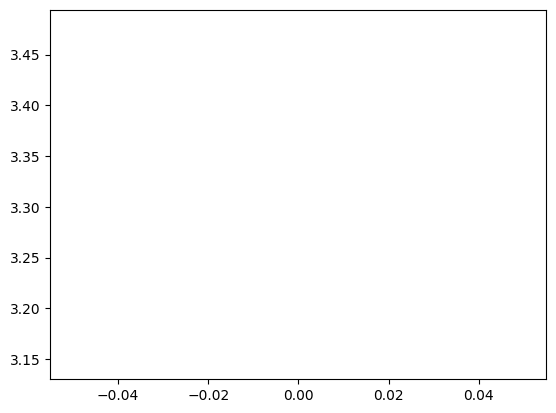

In [403]:
plt.plot(range(step_i), loss_i)

In [ ]:
@torch.no_grad()
def split_loss(split):
    X, Y = {"train": (Xtr, Ytr), "dev": (Xdev, Ydev), "test": (Xtest, Ytest)}[split] #!!!
    emb = C[X]
    h_preact = emb.view(-1, emb_dim * block_size) @ W1 #+ b1
    h_preact = bngain * ((h_preact - bnmean_running) / (bnstd_running + eps)) + bnbias
    h = torch.tanh(h_preact) # hidden layer, (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Y) # more efficient, prevents inf and nan for big positive logits
    print(split, loss.item())

In [141]:
# find out the loss for a whole (TR!) data set, not just a minibatch
split_loss("train")

# tr loss ~= dev loss -> not overfitting (actually maybe underfitting!)
# <=> nn not able to memorize the values
# might mean that the network is too small (not enough parameters)

# find out the loss for a whole (DEV!) data set
split_loss("dev")

train 26.225982666015625
dev 26.1970157623291


In [66]:
# SAMPLING
gen = torch.Generator().manual_seed(2147483647)

for _ in range(20):
    name = []
    context = [0] * block_size # initialize with all ...
    while True: # create one name
        emb = C[torch.tensor([context])] # like C[X] but this time only 1 context
        # block_size x emb_dim
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        idx = torch.multinomial(probs, num_samples=1, generator=gen).item()
        context = context[1:] + [idx]
        name.append(idx)
        if idx == 0:
            break
    print("".join(itoc[i] for i in name))
        

junide.
jakarie.
prefay.
adiya.
jiin.
tolian.
juha.
kilania.
zamileneas.
dedaine.
imel.
seon.
evyla.
terindtumeryf.
demmer.
fynsleigh.
aniya.
reaya.
zonna.
jaani.


In [67]:
C[Xtr].shape, Xtr.shape

(torch.Size([182580, 4, 8]), torch.Size([182580, 4]))

In [68]:
C[Xtr[2]] # idx (here 0) gets 1 context of 3 letters (2 * 3 = 6 embeddings)

tensor([[ 2.7741,  0.1895,  0.2226, -1.4316,  0.9183,  0.0130, -2.0440,  0.7489],
        [ 2.7741,  0.1895,  0.2226, -1.4316,  0.9183,  0.0130, -2.0440,  0.7489],
        [-1.0347, -0.2561, -0.2511, -0.3260, -0.7882,  0.5245, -0.2778,  1.0756],
        [ 2.1224,  0.3124,  0.8409, -1.1370,  0.8943, -0.3745, -1.9250,  0.6182]],
       grad_fn=<IndexBackward0>)

In [188]:
# VISUALIZATION

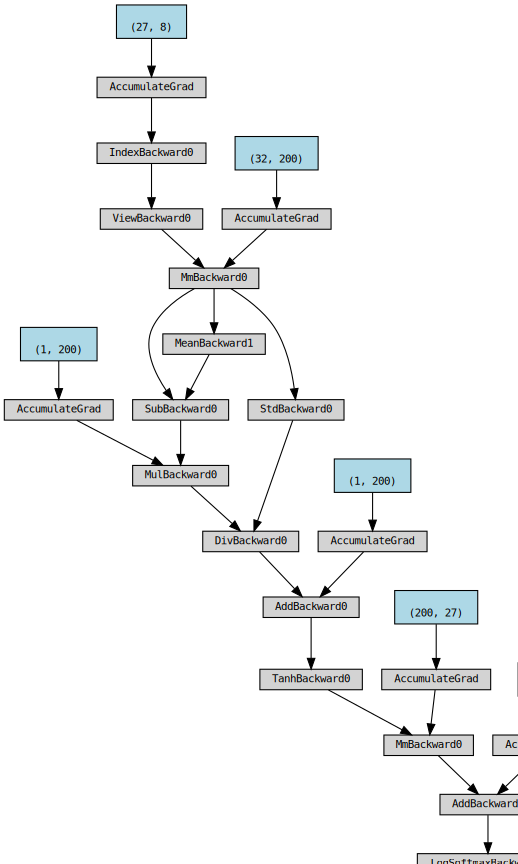

In [192]:
from torchviz import make_dot
from IPython.display import display
graph = make_dot(loss)
display(graph) # W O W ! ! ! ! ! ! !

In [193]:
# Save the graph as a PDF file
graph.render("computation_graph")

'computation_graph.pdf'

In [194]:
print(loss.grad_fn)

In [195]:
print(loss.grad_fn.next_functions)

((<LogSoftmaxBackward0 object at 0x7f2e56795240>, 0),)


In [196]:
print(loss.grad_fn.next_functions[0][0].next_functions)

((<AddBackward0 object at 0x7f2e56794ac0>, 0),)


In [197]:
print(loss.grad_fn.next_functions[0][0].next_functions[0][0].next_functions)
# etc. -> that's how we could build such graph!

((<MmBackward0 object at 0x7f2e56795b70>, 0), (<AccumulateGrad object at 0x7f2e56795720>, 0))
